In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.manifold import TSNE
import time
import warnings
warnings.filterwarnings("ignore")
import can
import json
from sklearn.model_selection import GridSearchCV

# READ DATA

In [44]:
with open('/Users/mariaallayioti/Desktop/ad_models/temp/output/prep_data.pkl', 'rb') as file:
    prep_data = pickle.load(file)
with open('/Users/mariaallayioti/Desktop/ad_models/temp/output/prep_data_inf.pkl', 'rb') as file:
    prep_data_inf = pickle.load(file)

In [45]:
X_train = prep_data['X_train']
X_val = prep_data['X_val']
y_train = prep_data['y_train']
y_val = prep_data['y_val']
X_test = prep_data_inf['X_inf']
y_test = prep_data_inf['y_inf']

# MODEL

In [8]:
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=LOOKBACK_SIZE, out_channels=32, kernel_size=3)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=32, out_channels=16, kernel_size=3)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.flatten_layer = torch.nn.Flatten()
        self.dense_1_layer = torch.nn.Linear(112, 32)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.3)
        self.dense_2_layer = torch.nn.Linear(32, DIMENSION)
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)

In [ ]:
class DeepAnT(torch.nn.Module):
    """
        Model : Class for DeepAnT model
    """
    def __init__(self, LOOKBACK_SIZE, DIMENSION):
        super(DeepAnT, self).__init__()
        self.conv1d_1_layer = torch.nn.Conv1d(in_channels=LOOKBACK_SIZE, out_channels=32, kernel_size=3)
        self.relu_1_layer = torch.nn.ReLU()
        self.maxpooling_1_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.conv1d_2_layer = torch.nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3)
        self.relu_2_layer = torch.nn.ReLU()
        self.maxpooling_2_layer = torch.nn.MaxPool1d(kernel_size=2)
        self.flatten_layer = torch.nn.Flatten()
        
        # Calculate the size of the flattened tensor
        self.flattened_size = self._calculate_flattened_size(LOOKBACK_SIZE)
        
        #self.dense_1_layer = torch.nn.Linear(224, 32)
        self.dense_1_layer = torch.nn.Linear(self.flattened_size, 32)
        self.relu_3_layer = torch.nn.ReLU()
        self.dropout_layer = torch.nn.Dropout(p=0.3)
        self.dense_2_layer = torch.nn.Linear(32, DIMENSION)
        
    def _calculate_flattened_size(self, lookback_size):
        dummy_input = torch.randn(3, lookback_size, 36)  # Create a dummy input
        x = self.conv1d_1_layer(dummy_input)
        print(x.shape)
        x = self.relu_1_layer(x)
        print(x.shape)
        x = self.maxpooling_1_layer(x)
        print(x.shape)
        x = self.conv1d_2_layer(x)
        print(x.shape)
        x = self.relu_2_layer(x)
        print(x.shape)
        x = self.maxpooling_2_layer(x)
        print(x.shape)
        x = self.flatten_layer(x)
        print(x.shape)
        return x.shape
        
    def forward(self, x):
        x = self.conv1d_1_layer(x)
        x = self.relu_1_layer(x)
        x = self.maxpooling_1_layer(x)
        x = self.conv1d_2_layer(x)
        x = self.relu_2_layer(x)
        x = self.maxpooling_2_layer(x)
        x = self.flatten_layer(x)
        dense_1_in = x.shape[1]
        x = self.dense_1_layer(x)
        x = self.relu_3_layer(x)
        x = self.dropout_layer(x)
        return self.dense_2_layer(x)


#Parameters
num_epochs = 200
batch_size = 32

# Parameters for early stopping
patience = 10
best_val_loss = float('inf')
epochs_no_improve = 0


model = DeepAnT(2,36)
loss_fn = torch.nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(list(model.parameters()), lr=1e-5)

# Dataloader
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.float32)))
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False)
x_tr = torch.tensor(X_train.astype(np.float32))
y_tr = torch.tensor(y_train.astype(np.float32))
x_v = torch.tensor(X_val.astype(np.float32))
y_v = torch.tensor(y_val.astype(np.float32))
x_te = torch.tensor(X_test.astype(np.float32))
y_te = torch.tensor(y_test.astype(np.float32))

# Training
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_X)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation
    model.eval()
    with torch.no_grad():
        val_output = model(x_v)
        val_loss = loss_fn(val_output, y_v)

    running_loss /= len(train_loader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss}, Val Loss: {val_loss.item()}')
    
    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f'Early stopping on epoch {epoch + 1}')
            break

# EXPERIMENT WITH THRESHOLD VALUE

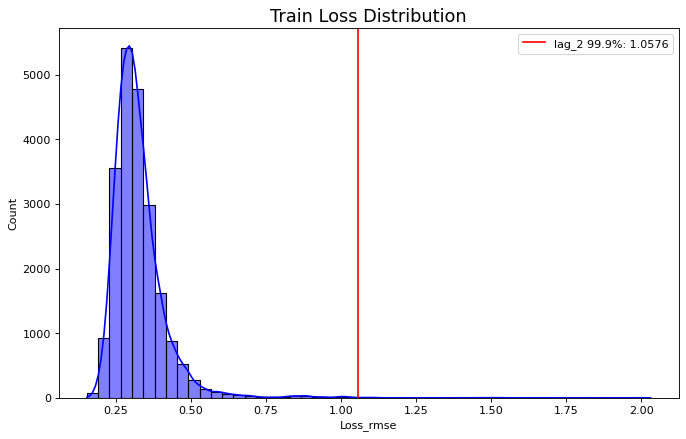

22


In [49]:
TIME_STEPS = 2

thresh_=0.999

y_pred_train = model(x_tr)

scored = pd.DataFrame()

#scored['Loss_mae'] = np.mean(torch.abs(y_pred_train- y_tr).detach().cpu().numpy(), axis=1)
scored['Loss_rmse'] = np.sqrt(torch.sum((y_pred_train - y_tr) ** 2, dim=1).detach().cpu().numpy())

scored['Threshold'] = scored['Loss_rmse'].quantile(thresh_)
scored['Anomaly'] = scored['Loss_rmse'] > scored['Threshold']

plt.figure(figsize=(10,6), dpi=80)
plt.title('Train Loss Distribution', fontsize=16)
sns.histplot(scored['Loss_rmse'], bins = 50, kde= True, color = 'blue',alpha=0.5);
plt.axvline(x=scored['Loss_rmse'].quantile(thresh_),color='red',label=f"lag_{TIME_STEPS} {thresh_*100}%: {scored['Loss_rmse'].quantile(thresh_).round(4)}")
plt.legend(loc="upper right")
plt.show()

print(scored.Anomaly.sum())

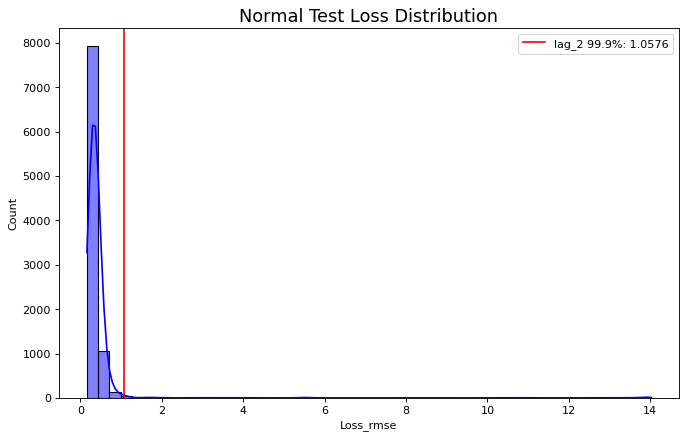

99


In [50]:
y_pred_val = model(x_v)

scored_val = pd.DataFrame()
#scored_val['Loss_mae'] = np.mean(torch.abs(y_pred_val- y_v).detach().cpu().numpy(), axis=1)
scored_val['Loss_rmse']  = np.sqrt(torch.sum((y_pred_val - y_v) ** 2, dim=1).detach().cpu().numpy())
scored_val['Threshold'] = scored['Loss_rmse'].quantile(thresh_)
scored_val['Anomaly'] = scored_val['Loss_rmse'] > scored_val['Threshold']

plt.figure(figsize=(10,6), dpi=80)
plt.title('Normal Test Loss Distribution', fontsize=16)
sns.histplot(scored_val['Loss_rmse'], bins = 50, kde= True, color = 'blue',alpha=0.5);
plt.axvline(x=scored['Loss_rmse'].quantile(thresh_),color='red',label=f"lag_{TIME_STEPS} {thresh_*100}%: {scored['Loss_rmse'].quantile(thresh_).round(4)}")
plt.legend(loc="upper right")
plt.show()

print(scored_val.Anomaly.sum())

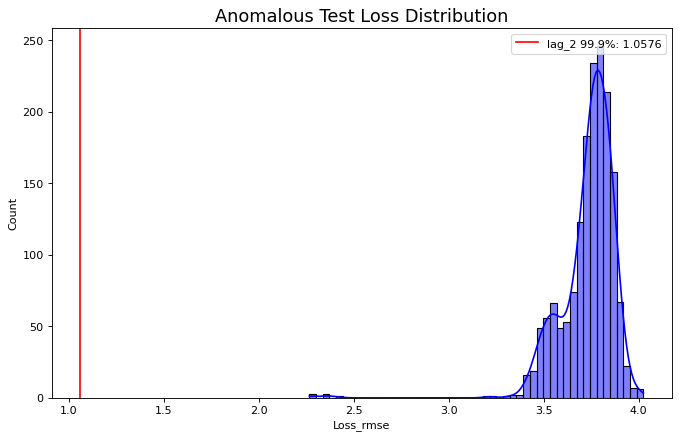

0


In [51]:
y_pred_test = model(x_te)

scored_test = pd.DataFrame()

#scored_test['Loss_mae'] = np.mean(torch.abs(y_pred_test - y_te).detach().cpu().numpy(), axis=1)
scored_test['Loss_rmse'] = np.sqrt(torch.sum((y_pred_test - y_te) ** 2, dim=1).detach().cpu().numpy())
scored_test['Threshold'] = scored['Loss_rmse'].quantile(thresh_)
scored_test['Anomaly'] = scored_test['Loss_rmse'] > scored_test['Threshold']
plt.figure(figsize=(10,6), dpi=80)
plt.title('Anomalous Test Loss Distribution', fontsize=16)
sns.histplot(scored_test['Loss_rmse'], bins = 50, kde= True, color = 'blue',alpha=0.5);
plt.axvline(x=scored['Loss_rmse'].quantile(thresh_),color='red',label=f"lag_{TIME_STEPS} {thresh_*100}%: {scored['Loss_rmse'].quantile(thresh_).round(4)}")
plt.legend(loc="upper right")
plt.show()

print(len(scored_test)-scored_test.Anomaly.sum())